# Notebook 05: Exploratory Data Analysis (EDA)

**Purpose**: Deep dive into monthly aggregated data to understand patterns, seasonality, and trends

**Input**: `data/processed/monthly_aggregated.csv`

**Output**: 
- Seasonal decomposition results
- Correlation analysis
- Pattern identification
- Insights for model selection

**Author**: Kevin Kuhn  
**Date**: 2025-10-17

In [65]:
# Import libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

from utils.traveco_utils import ConfigLoader, load_processed_data

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis timestamp: 2025-10-24 11:43:20


## 1. Load Configuration and Data

In [66]:
# Load configuration (use relative path from notebooks directory)
config = ConfigLoader('../config/config.yaml')

# Load monthly aggregated data
df = load_processed_data('monthly_aggregated.csv', config)

# First, let's see what columns we have
print(f"\nAvailable columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Convert year_month to datetime (handle different possible column names)
if 'year_month' in df.columns:
    df['year_month'] = pd.to_datetime(df['year_month'])
elif 'date' in df.columns:
    df['year_month'] = pd.to_datetime(df['date'])
else:
    print(f"⚠️  Warning: No date column found. Available columns: {list(df.columns)}")

print(f"\nData shape: {df.shape}")

if 'year_month' in df.columns:
    print(f"Date range: {df['year_month'].min()} to {df['year_month'].max()}")
    print(f"Unique dates: {df['year_month'].nunique()}")

# Check for branch column (could be named differently)
branch_col = None
for possible_name in ['betriebszentrale_name', 'Nummer.Auftraggeber', 'Niederlassung', 'branch', 'Branch', 'branch_name']:
    if possible_name in df.columns:
        branch_col = possible_name
        break

if branch_col:
    print(f"\nBranches (using '{branch_col}'): {df[branch_col].nunique()}")
else:
    print(f"\n⚠️  No branch column found - data may already be aggregated to company level")


Loaded 12 rows from: ../data/processed/monthly_aggregated.csv

Available columns: ['year_month', 'betriebszentrale_name', 'total_orders', 'revenue_total', 'total_costs', 'external_carrier_costs', 'total_distance_km', 'avg_distance_km', 'median_distance_km', 'external_driver_orders', 'internal_driver_orders', 'delivery_orders', 'pickup_orders', 'leergut_orders', 'retoure_orders', 'unique_sparten_count', 'profit_margin', 'revenue_per_order', 'cost_per_order', 'date', 'year', 'month', 'quarter', 'month_name', 'split']

First few rows:
  year_month betriebszentrale_name  total_orders  revenue_total   total_costs  \
0    2025-06         B&T Landquart           599   9.989745e+04  9.987450e+04   
1    2025-06           B&T Puidoux          2444   4.911522e+05  4.672187e+05   
2    2025-06        B&T Winterthur          9161   8.803983e+05  1.097530e+06   
3    2025-06    BZ Herzogenbuchsee          6186   2.775538e+06  2.740018e+06   
4    2025-06  BZ Intermodal / Rail           425   1.7541

In [67]:
# Display sample data
print("\n=== Sample Data ===")
display(df.head(10))

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Summary Statistics ===")
display(df.describe())


=== Sample Data ===


,year_month,betriebszentrale_name,total_orders,revenue_total,total_costs,external_carrier_costs,total_distance_km,avg_distance_km,median_distance_km,external_driver_orders,...,unique_sparten_count,profit_margin,revenue_per_order,cost_per_order,date,year,month,quarter,month_name,split
0,2025-06-01,B&T Landquart,599,9.989745e+04,9.987450e+04,9.987450e+04,15867.0,26.489149,21.0,0,...,1,0.022974,166.773706,166.735392,2025-06-01,2025,6,2,June,train
1,2025-06-01,B&T Puidoux,2444,4.911522e+05,4.672187e+05,4.672187e+05,119729.0,48.988953,37.0,0,...,1,4.872910,200.962418,191.169701,2025-06-01,2025,6,2,June,train
2,2025-06-01,B&T Winterthur,9161,8.803983e+05,1.097530e+06,1.097530e+06,167109.0,28.010225,22.0,0,...,3,-24.662895,96.102854,119.804601,2025-06-01,2025,6,2,June,train
3,2025-06-01,BZ Herzogenbuchsee,6186,2.775538e+06,2.740018e+06,2.733261e+06,402215.0,65.167693,55.0,455,...,5,1.279742,448.680542,442.938590,2025-06-01,2025,6,2,June,train
4,2025-06-01,BZ Intermodal / Rail,425,1.754133e+05,2.121609e+05,2.121609e+05,23334.0,96.421488,149.0,140,...,3,-20.949097,412.737271,499.202000,2025-06-01,2025,6,2,June,train
5,2025-06-01,BZ Landquart,16703,7.048027e+05,6.603487e+05,6.603487e+05,1038111.0,62.151170,62.0,4327,...,4,6.307293,42.196176,39.534739,2025-06-01,2025,6,2,June,train
6,2025-06-01,BZ Oberbipp,35980,1.289775e+06,1.091089e+06,1.091089e+06,2524066.0,70.151918,59.0,9082,...,1,15.404676,35.846996,30.324882,2025-06-01,2025,6,2,June,train
7,2025-06-01,BZ Puidoux,1612,1.577397e+05,1.508678e+05,1.493744e+05,89940.0,55.794045,44.5,195,...,2,4.356497,97.853412,93.590431,2025-06-01,2025,6,2,June,train
8,2025-06-01,BZ Sierre,5373,2.174266e+05,2.143313e+05,2.143313e+05,221673.0,41.256840,26.0,81,...,2,1.423607,40.466518,39.890434,2025-06-01,2025,6,2,June,train
9,2025-06-01,BZ Sursee,28893,4.755496e+06,4.704101e+06,4.591244e+06,2284176.0,85.633051,79.0,4909,...,6,1.080752,164.589916,162.811107,2025-06-01,2025,6,2,June,train



=== Data Types ===
year_month                datetime64[ns]
betriebszentrale_name             object
total_orders                       int64
revenue_total                    float64
total_costs                      float64
external_carrier_costs           float64
total_distance_km                float64
avg_distance_km                  float64
median_distance_km               float64
external_driver_orders             int64
internal_driver_orders             int64
delivery_orders                    int64
pickup_orders                      int64
leergut_orders                     int64
retoure_orders                     int64
unique_sparten_count               int64
profit_margin                    float64
revenue_per_order                float64
cost_per_order                   float64
date                              object
year                               int64
month                              int64
quarter                            int64
month_name                        obj

,year_month,total_orders,revenue_total,total_costs,external_carrier_costs,total_distance_km,avg_distance_km,median_distance_km,external_driver_orders,internal_driver_orders,...,pickup_orders,leergut_orders,retoure_orders,unique_sparten_count,profit_margin,revenue_per_order,cost_per_order,year,month,quarter
count,12,12.000000,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,11.000000,11.000000,12.000000,12.000000,...,12.00000,12.000000,12.000000,12.000000,11.000000,12.000000,12.000000,12.0,12.0,12.0
mean,2025-06-01 00:00:00,11303.833333,1.063045e+06,1.045584e+06,1.035480e+06,6.800668e+05,56.883395,53.681818,2065.166667,8891.500000,...,1404.75000,2068.250000,2068.250000,2.833333,-0.239818,145.792518,152.145050,2025.0,6.0,2.0
min,2025-06-01 00:00:00,351.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,26.489149,21.000000,0.000000,285.000000,...,0.00000,0.000000,0.000000,1.000000,-24.662895,0.000000,0.000000,2025.0,6.0,2.0
25%,2025-06-01 00:00:00,1358.750000,1.709949e+05,1.968376e+05,1.964642e+05,7.328850e+04,43.454828,31.000000,0.000000,1212.250000,...,0.00000,0.000000,0.000000,1.000000,0.551863,41.763761,39.687724,2025.0,6.0,2.0
50%,2025-06-01 00:00:00,5779.500000,5.979774e+05,5.637837e+05,5.637837e+05,1.943910e+05,55.794045,44.500000,167.500000,5511.500000,...,181.50000,1.000000,1.000000,2.500000,1.423607,96.978133,106.697516,2025.0,6.0,2.0
75%,2025-06-01 00:00:00,19507.000000,1.229122e+06,1.100514e+06,1.100480e+06,1.097228e+06,67.659805,60.500000,4472.500000,14863.500000,...,2180.75000,2719.250000,2719.250000,4.250000,5.590101,175.320884,172.843970,2025.0,6.0,2.0
max,2025-06-01 00:00:00,35980.000000,4.755496e+06,4.704101e+06,4.591244e+06,2.524066e+06,96.421488,149.000000,9082.000000,26898.000000,...,6160.00000,9353.000000,9353.000000,6.000000,15.404676,448.680542,499.202000,2025.0,6.0,2.0
std,NaN,12844.527649,1.398328e+06,1.379108e+06,1.351324e+06,9.046734e+05,22.030730,36.522782,3099.528317,10009.791211,...,2000.95078,3351.387287,3351.387287,1.800673,11.994971,146.870080,161.594092,0.0,0.0,0.0


## 2. Time Series Decomposition

Decompose time series into:
- **Trend**: Long-term increase/decrease
- **Seasonal**: Repeating patterns (yearly, quarterly, monthly)
- **Residual**: Random noise

In [68]:
# Aggregate to total company level for decomposition
# Check if data is already at company level or needs aggregation

# Identify branch column
branch_col = None
for possible_name in ['betriebszentrale_name', 'Nummer.Auftraggeber', 'Niederlassung', 'branch', 'Branch', 'branch_name']:
    if possible_name in df.columns:
        branch_col = possible_name
        break

# Define target columns (check which exist)
target_cols_to_agg = {}
if 'total_orders' in df.columns:
    target_cols_to_agg['total_orders'] = 'sum'
if 'external_driver_orders' in df.columns:
    target_cols_to_agg['external_driver_orders'] = 'sum'
if 'internal_driver_orders' in df.columns:
    target_cols_to_agg['internal_driver_orders'] = 'sum'
if 'total_distance_km' in df.columns:
    target_cols_to_agg['total_distance_km'] = 'sum'

if branch_col and len(target_cols_to_agg) > 0:
    # Data has branches, aggregate to company level
    df_total = df.groupby('year_month').agg(target_cols_to_agg).reset_index()
    print(f"Aggregated from {df[branch_col].nunique()} branches to company level")
elif 'year_month' in df.columns and len(target_cols_to_agg) > 0:
    # Data appears to already be at company level
    df_total = df.copy()
    print("Data appears to already be at company level (no branch column)")
else:
    # Fallback - use all numeric columns
    print("⚠️  Using fallback aggregation")
    df_total = df.copy()

# Sort by date
if 'year_month' in df_total.columns:
    df_total = df_total.sort_values('year_month').reset_index(drop=True)
    print(f"\nTotal company time series: {len(df_total)} months")
    print(f"From {df_total['year_month'].min()} to {df_total['year_month'].max()}")
else:
    print("⚠️  Cannot sort - no year_month column")


Data appears to already be at company level (no branch column)

Total company time series: 12 months
From 2025-06-01 00:00:00 to 2025-06-01 00:00:00


In [69]:
# Seasonal decomposition for total orders
# Using additive model (better for stable variance)
# Period = 12 months for yearly seasonality

if len(df_total) >= 24:  # Need at least 2 years for good decomposition
    decomposition = seasonal_decompose(
        df_total.set_index('year_month')['total_orders'],
        model='additive',
        period=12,
        extrapolate_trend='freq'
    )
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 10))
    
    decomposition.observed.plot(ax=axes[0], title='Observed')
    axes[0].set_ylabel('Orders')
    
    decomposition.trend.plot(ax=axes[1], title='Trend')
    axes[1].set_ylabel('Orders')
    
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    axes[2].set_ylabel('Orders')
    
    decomposition.resid.plot(ax=axes[3], title='Residual')
    axes[3].set_ylabel('Orders')
    
    plt.tight_layout()
    plt.savefig('../results/seasonal_decomposition_total_orders.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate strength of trend and seasonality
    var_resid = decomposition.resid.var()
    var_trend = decomposition.trend.var()
    var_seasonal = decomposition.seasonal.var()
    
    trend_strength = max(0, 1 - var_resid / (var_resid + var_trend))
    seasonal_strength = max(0, 1 - var_resid / (var_resid + var_seasonal))
    
    print("\n=== Decomposition Analysis ===")
    print(f"Trend strength: {trend_strength:.2%}")
    print(f"Seasonal strength: {seasonal_strength:.2%}")
    print(f"\nInterpretation:")
    print(f"  - Strong trend (>70%): {'Yes' if trend_strength > 0.7 else 'No'}")
    print(f"  - Strong seasonality (>70%): {'Yes' if seasonal_strength > 0.7 else 'No'}")
else:
    print(f"⚠️  Need at least 24 months for seasonal decomposition. Current: {len(df_total)} months")

⚠️  Need at least 24 months for seasonal decomposition. Current: 12 months


## 3. Autocorrelation Analysis

Identify:
- **ACF (Autocorrelation)**: How current values relate to past values
- **PACF (Partial Autocorrelation)**: Direct relationship after removing intermediate correlations
- Useful for SARIMAX order selection (p, d, q parameters)

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 10 must be < 6.

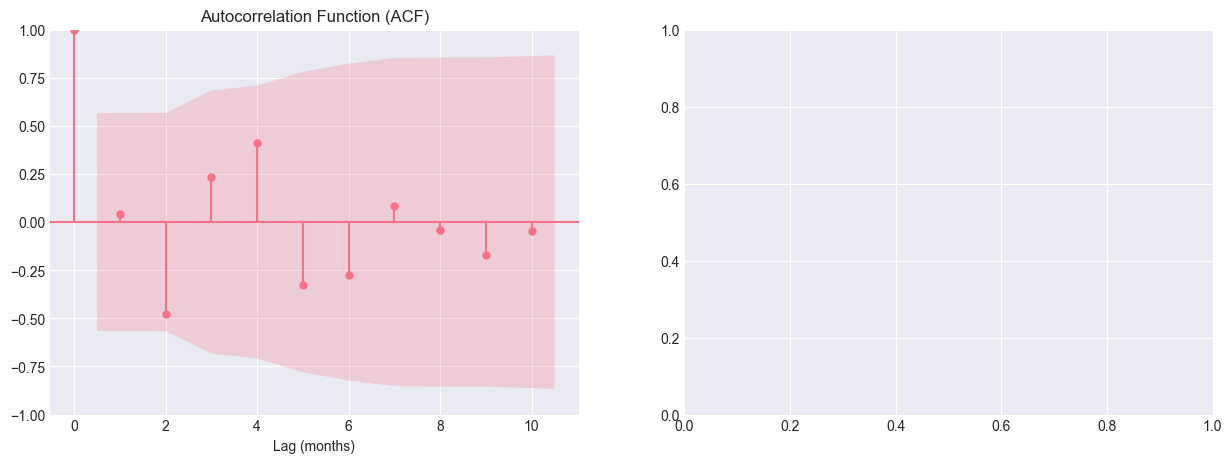

In [70]:
# ACF and PACF plots
# Only run if we have enough data points

if len(df_total) >= 10:  # Need at least 10 data points for meaningful ACF/PACF
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Limit lags to at most len(data) - 2
    max_lags = min(24, len(df_total) - 2)
    
    # ACF
    plot_acf(df_total['total_orders'].dropna(), lags=max_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[0].set_xlabel('Lag (months)')
    
    # PACF
    plot_pacf(df_total['total_orders'].dropna(), lags=max_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    axes[1].set_xlabel('Lag (months)')
    
    plt.tight_layout()
    plt.savefig('../results/acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n=== ACF/PACF Interpretation Guide ===")
    print("For SARIMAX(p,d,q)(P,D,Q)[s] parameter selection:")
    print("  - ACF shows significant spikes at seasonal lags (12, 24) → Q parameter")
    print("  - PACF shows significant spikes at seasonal lags → P parameter")
    print("  - ACF decays gradually → MA component (q parameter)")
    print("  - PACF cuts off sharply → AR component (p parameter)")
else:
    print(f"⚠️  Skipping ACF/PACF analysis - insufficient data ({len(df_total)} time periods)")
    print(f"    Time series analysis requires multiple time periods (months/weeks)")
    print(f"    Current data appears to be from a single time period with multiple groups (branches)")

## 4. Seasonality Patterns by Month

In [ ]:
# Extract month and year for analysis
df_total['month'] = df_total['year_month'].dt.month
df_total['year'] = df_total['year_month'].dt.year

# Monthly patterns
monthly_avg = df_total.groupby('month')['total_orders'].agg(['mean', 'std', 'min', 'max']).reset_index()
monthly_avg['cv'] = monthly_avg['std'] / monthly_avg['mean']  # Coefficient of variation

# Create month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg['month_name'] = monthly_avg['month'].apply(lambda x: month_names[x-1])

print("\n=== Monthly Seasonality Patterns ===")
display(monthly_avg)

# Visualize monthly patterns
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthly_avg['month_name'],
    y=monthly_avg['mean'],
    error_y=dict(type='data', array=monthly_avg['std']),
    name='Average Orders',
    marker_color='lightblue'
))

fig.update_layout(
    title='Average Monthly Orders (±1 Std Dev)',
    xaxis_title='Month',
    yaxis_title='Total Orders',
    height=500,
    showlegend=False
)

fig.write_html('../results/monthly_seasonality.html')
fig.show()

# Identify peak and low months
peak_month = monthly_avg.loc[monthly_avg['mean'].idxmax(), 'month_name']
low_month = monthly_avg.loc[monthly_avg['mean'].idxmin(), 'month_name']
peak_value = monthly_avg['mean'].max()
low_value = monthly_avg['mean'].min()
seasonality_amplitude = ((peak_value - low_value) / monthly_avg['mean'].mean()) * 100

print(f"\n📊 Peak month: {peak_month} ({peak_value:.0f} orders)")
print(f"📉 Low month: {low_month} ({low_value:.0f} orders)")
print(f"📈 Seasonality amplitude: {seasonality_amplitude:.1f}%")

## 5. Year-over-Year Growth Analysis

In [ ]:
# Calculate year-over-year growth
yearly_totals = df_total.groupby('year').agg({
    'total_orders': 'sum',
    'external_driver_orders': 'sum',
    'internal_driver_orders': 'sum',
    'total_distance_km': 'sum'
}).reset_index()

yearly_totals['yoy_growth'] = yearly_totals['total_orders'].pct_change() * 100
yearly_totals['external_pct'] = (yearly_totals['external_driver_orders'] / yearly_totals['total_orders']) * 100
yearly_totals['internal_pct'] = (yearly_totals['internal_driver_orders'] / yearly_totals['total_orders']) * 100

print("\n=== Year-over-Year Analysis ===")
display(yearly_totals)

# Visualize yearly trends
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Total Orders by Year', 'YoY Growth Rate',
                   'External vs Internal Split', 'Total Distance')
)

# Total orders
fig.add_trace(
    go.Bar(x=yearly_totals['year'], y=yearly_totals['total_orders'],
           marker_color='steelblue', name='Orders'),
    row=1, col=1
)

# YoY growth
fig.add_trace(
    go.Bar(x=yearly_totals['year'][1:], y=yearly_totals['yoy_growth'][1:],
           marker_color='coral', name='Growth %'),
    row=1, col=2
)

# External vs Internal
fig.add_trace(
    go.Bar(x=yearly_totals['year'], y=yearly_totals['external_pct'],
           name='External %', marker_color='lightcoral'),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=yearly_totals['year'], y=yearly_totals['internal_pct'],
           name='Internal %', marker_color='lightgreen'),
    row=2, col=1
)

# Total distance
fig.add_trace(
    go.Bar(x=yearly_totals['year'], y=yearly_totals['total_distance_km'],
           marker_color='mediumpurple', name='Distance'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=True, title_text="Yearly Trends Analysis")
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=2)
fig.update_yaxes(title_text="Orders", row=1, col=1)
fig.update_yaxes(title_text="Growth %", row=1, col=2)
fig.update_yaxes(title_text="Percentage", row=2, col=1)
fig.update_yaxes(title_text="Distance (km)", row=2, col=2)

fig.write_html('../results/yearly_trends_analysis.html')
fig.show()

# Calculate average growth rate
avg_growth = yearly_totals['yoy_growth'].mean()
print(f"\n📈 Average YoY growth rate: {avg_growth:.2f}%")

## 6. Branch-Level Correlation Analysis

In [ ]:
# Branch-Level Correlation Analysis
# Only run if we have branch-level data

# Find branch column
branch_col = None
for possible_name in ['betriebszentrale_name', 'Nummer.Auftraggeber', 'Niederlassung', 'branch', 'Branch', 'branch_name']:
    if possible_name in df.columns:
        branch_col = possible_name
        break

if branch_col and 'total_orders' in df.columns:
    # Get top branches by total volume
    top_branches = df.groupby(branch_col)['total_orders'].sum().nlargest(10).index.tolist()
    
    # Create pivot table for correlation
    df_pivot = df[df[branch_col].isin(top_branches)].pivot(
        index='year_month',
        columns=branch_col,
        values='total_orders'
    )
    
    # Calculate correlation matrix
    correlation_matrix = df_pivot.corr()
    
    print("\n=== Branch Correlation Matrix (Top 10 Branches) ===")
    print("High correlation (>0.8) indicates similar patterns")
    print("Low correlation (<0.3) indicates independent patterns\n")
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
    plt.title('Branch Order Correlation Matrix (Top 10 Branches)', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig('../results/branch_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find highly correlated branch pairs
    high_corr_threshold = 0.8
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > high_corr_threshold:
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"\n🔗 Highly correlated branch pairs (correlation > {high_corr_threshold}):")
        for branch1, branch2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
            print(f"  {branch1} ↔ {branch2}: {corr:.3f}")
    else:
        print(f"\nNo branch pairs with correlation > {high_corr_threshold}")
else:
    print("⚠️  Skipping branch correlation analysis - no branch column found in data")
    print("    Data appears to already be aggregated at company level")


## 7. Target Variable Correlation

In [ ]:
# Correlation between target variables
target_cols = ['total_orders', 'external_driver_orders', 'internal_driver_orders', 'total_distance_km']
available_targets = [col for col in target_cols if col in df_total.columns]

if len(available_targets) > 1:
    target_correlation = df_total[available_targets].corr()
    
    print("\n=== Target Variable Correlations ===")
    display(target_correlation)
    
    # Visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(target_correlation, annot=True, fmt='.3f', cmap='RdYlGn',
                center=0, vmin=-1, vmax=1, square=True, linewidths=1)
    plt.title('Target Variable Correlation Matrix', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig('../results/target_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Pairplot for visual inspection
    if len(df_total) < 500:  # Only if not too many data points
        pairplot_data = df_total[available_targets].copy()
        fig = px.scatter_matrix(
            pairplot_data,
            dimensions=available_targets,
            title='Target Variable Pairplot',
            height=800
        )
        fig.update_traces(diagonal_visible=False, showupperhalf=False)
        fig.write_html('../results/target_pairplot.html')
        fig.show()
else:
    print("Not enough target variables for correlation analysis")

## 8. Stationarity Test (Augmented Dickey-Fuller)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name=''):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    
    Null hypothesis: Series has a unit root (non-stationary)
    If p-value < 0.05: Reject null hypothesis (stationary)
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n=== ADF Test Results: {name} ===")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] < 0.05:
        print(f"\n✅ Result: STATIONARY (p-value < 0.05)")
        print("   → Can use without differencing")
        return True
    else:
        print(f"\n❌ Result: NON-STATIONARY (p-value >= 0.05)")
        print("   → Need differencing (d=1 in SARIMAX)")
        return False

# Test original series
is_stationary = adf_test(df_total['total_orders'], 'Total Orders (Original)')

# Test first difference if non-stationary
if not is_stationary:
    df_total['total_orders_diff'] = df_total['total_orders'].diff()
    adf_test(df_total['total_orders_diff'], 'Total Orders (First Difference)')
    
    # Visualize original vs differenced
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    axes[0].plot(df_total['year_month'], df_total['total_orders'])
    axes[0].set_title('Original Series')
    axes[0].set_ylabel('Total Orders')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(df_total['year_month'][1:], df_total['total_orders_diff'][1:])
    axes[1].set_title('First Difference (Δ orders)')
    axes[1].set_ylabel('Change in Orders')
    axes[1].set_xlabel('Date')
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/stationarity_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## 9. Distribution Analysis

In [ ]:
# Analyze distribution of target variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

target_vars = [
    ('total_orders', 'Total Orders'),
    ('external_driver_orders', 'External Driver Orders'),
    ('internal_driver_orders', 'Internal Driver Orders'),
    ('total_distance_km', 'Total Distance (km)')
]

for idx, (col, title) in enumerate(target_vars):
    if col in df_total.columns:
        row = idx // 2
        col_idx = idx % 2
        
        data = df_total[col].dropna()
        
        # Histogram with KDE
        axes[row, col_idx].hist(data, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        axes[row, col_idx].set_title(f'{title} Distribution')
        axes[row, col_idx].set_xlabel(title)
        axes[row, col_idx].set_ylabel('Frequency')
        
        # Add mean and median lines
        mean_val = data.mean()
        median_val = data.median()
        axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
        axes[row, col_idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.0f}')
        axes[row, col_idx].legend()
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # Perform normality test
        statistic, p_value = stats.shapiro(data)
        is_normal = p_value > 0.05
        normality_text = "Normal" if is_normal else "Non-normal"
        axes[row, col_idx].text(0.95, 0.95, f'{normality_text}\n(p={p_value:.3f})',
                               transform=axes[row, col_idx].transAxes,
                               verticalalignment='top', horizontalalignment='right',
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Distribution Statistics ===")
for col, title in target_vars:
    if col in df_total.columns:
        data = df_total[col].dropna()
        print(f"\n{title}:")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Std Dev: {data.std():.2f}")
        print(f"  Skewness: {data.skew():.2f}")
        print(f"  Kurtosis: {data.kurtosis():.2f}")

## 10. Outlier Detection

In [ ]:
# Detect outliers using IQR method
def detect_outliers_iqr(series, multiplier=1.5):
    """
    Detect outliers using Interquartile Range (IQR)
    
    multiplier=1.5: Standard outlier detection
    multiplier=3.0: Extreme outlier detection
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    return outliers, lower_bound, upper_bound

print("\n=== Outlier Detection (IQR Method) ===")

for col, title in target_vars:
    if col in df_total.columns:
        data = df_total[col].dropna()
        outliers, lower, upper = detect_outliers_iqr(data)
        
        print(f"\n{title}:")
        print(f"  Normal range: [{lower:.0f}, {upper:.0f}]")
        print(f"  Outliers detected: {len(outliers)}")
        
        if len(outliers) > 0:
            print(f"  Outlier values: {outliers.values}")
            outlier_dates = df_total.loc[outliers.index, 'year_month'].values
            print(f"  Outlier dates: {outlier_dates}")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (col, title) in enumerate(target_vars):
    if col in df_total.columns:
        row = idx // 2
        col_idx = idx % 2
        
        data = df_total[col].dropna()
        outliers, lower, upper = detect_outliers_iqr(data)
        
        # Box plot
        bp = axes[row, col_idx].boxplot([data], labels=[title], patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        
        axes[row, col_idx].set_title(f'{title} - Box Plot')
        axes[row, col_idx].set_ylabel('Value')
        axes[row, col_idx].grid(True, alpha=0.3, axis='y')
        
        # Add outlier count
        axes[row, col_idx].text(1.3, data.median(), f'{len(outliers)} outliers',
                               verticalalignment='center',
                               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('../results/outlier_detection.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Generate EDA Summary Report

In [ ]:
# Create comprehensive EDA summary

# Find branch column
branch_col = None
for possible_name in ['betriebszentrale_name', 'Nummer.Auftraggeber', 'Niederlassung', 'branch', 'Branch', 'branch_name']:
    if possible_name in df.columns:
        branch_col = possible_name
        break

num_branches = int(df[branch_col].nunique()) if branch_col else 1

eda_summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_summary': {
        'total_months': int(len(df_total)),
        'date_range': f"{df_total['year_month'].min()} to {df_total['year_month'].max()}",
        'num_branches': num_branches
    },
    'seasonality': {
        'seasonal_strength': float(seasonal_strength) if len(df_total) >= 24 else None,
        'trend_strength': float(trend_strength) if len(df_total) >= 24 else None,
        'peak_month': peak_month,
        'low_month': low_month,
        'seasonality_amplitude_pct': float(seasonality_amplitude)
    },
    'growth': {
        'avg_yoy_growth_pct': float(avg_growth) if not np.isnan(avg_growth) else None,
        'yearly_data': yearly_totals.to_dict('records')
    },
    'stationarity': {
        'is_stationary': bool(is_stationary),
        'recommended_differencing': 0 if is_stationary else 1
    },
    'model_recommendations': {}
}

# Add model recommendations based on findings
recommendations = []

if len(df_total) >= 24:
    if seasonal_strength > 0.7:
        recommendations.append("Strong seasonality detected → Prophet and SARIMAX recommended")
        recommendations.append("Use seasonal order (P,D,Q)[12] in SARIMAX")
    else:
        recommendations.append("Weak seasonality → Consider simpler models first")
else:
    recommendations.append(f"Limited data ({len(df_total)} months) → Use simpler models, avoid complex seasonal models")

if not is_stationary:
    recommendations.append("Non-stationary series → Use d=1 in SARIMAX")
else:
    recommendations.append("Stationary series → Can use d=0 in SARIMAX")

if not np.isnan(avg_growth) and abs(avg_growth) > 5:
    recommendations.append(f"Strong growth trend ({avg_growth:.1f}%) → Consider linear trend component")
else:
    recommendations.append("Stable growth → Standard trend handling sufficient")

eda_summary['model_recommendations']['insights'] = recommendations

# Save summary to JSON
with open('../results/eda_summary.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    def convert_types(obj):
        if isinstance(obj, dict):
            return {k: convert_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_types(item) for item in obj]
        elif isinstance(obj, (np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif pd.isna(obj):
            return None
        else:
            return obj
    
    eda_summary_clean = convert_types(eda_summary)
    json.dump(eda_summary_clean, f, indent=2)

print("\n" + "="*70)
print("📊 EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*70)

print(f"\n📅 Data Coverage:")
print(f"   {eda_summary['data_summary']['total_months']} months")
print(f"   {eda_summary['data_summary']['date_range']}")
print(f"   {eda_summary['data_summary']['num_branches']} branches")

if eda_summary['seasonality']['seasonal_strength']:
    print(f"\n📈 Seasonality:")
    print(f"   Strength: {eda_summary['seasonality']['seasonal_strength']:.1%}")
    print(f"   Peak month: {eda_summary['seasonality']['peak_month']}")
    print(f"   Low month: {eda_summary['seasonality']['low_month']}")
    print(f"   Amplitude: {eda_summary['seasonality']['seasonality_amplitude_pct']:.1f}%")

if eda_summary['growth']['avg_yoy_growth_pct']:
    print(f"\n📊 Growth:")
    print(f"   Average YoY: {eda_summary['growth']['avg_yoy_growth_pct']:.2f}%")

print(f"\n🔍 Stationarity:")
print(f"   {'Stationary' if eda_summary['stationarity']['is_stationary'] else 'Non-stationary'}")
print(f"   Recommended differencing: d={eda_summary['stationarity']['recommended_differencing']}")

print(f"\n💡 Model Recommendations:")
for rec in recommendations:
    print(f"   • {rec}")

print("\n" + "="*70)
print("✅ EDA Complete!")
print("="*70)
print("\n📁 Saved:")
print("   - results/eda_summary.json")
if len(df_total) >= 24:
    print("   - results/seasonal_decomposition_total_orders.png")
print("   - results/acf_pacf_analysis.png")
print("   - results/monthly_seasonality.html")
print("   - results/yearly_trends_analysis.html")
if branch_col:
    print("   - results/branch_correlation_matrix.png")
print("   - results/target_correlation_matrix.png")
if len(df_total) < 500:
    print("   - results/target_pairplot.html")
print("   - results/distribution_analysis.png")
print("   - results/outlier_detection.png")
print("\n➡️  NEXT STEPS:")
print("   Proceed to notebook 06: Baseline Models (Prophet)")


In [ ]:
# Import Path for file handling
from pathlib import Path

# Load tour cost data if available
tour_costs_file = Path('../data/processed/tour_costs.csv')

if tour_costs_file.exists():
    print("Loading tour cost data...")
    df_tour_costs = pd.read_csv(tour_costs_file)
    
    print(f"Loaded {len(df_tour_costs):,} tours with cost data")
    
    # Check if efficiency data exists
    if 'km_efficiency_ratio' in df_tour_costs.columns:
        print("\n📏 KM Efficiency Analysis:")
        
        # Filter out outliers for visualization
        efficiency_clean = df_tour_costs['km_efficiency_ratio'].dropna()
        efficiency_clean = efficiency_clean[(efficiency_clean > 0) & (efficiency_clean < 3)]
        
        print(f"   Mean efficiency ratio: {efficiency_clean.mean():.3f}")
        print(f"   Median efficiency ratio: {efficiency_clean.median():.3f}")
        print(f"   Std deviation: {efficiency_clean.std():.3f}")
        
        # Categorize efficiency
        excellent = (efficiency_clean < 0.9).sum()
        good = ((efficiency_clean >= 0.9) & (efficiency_clean < 1.0)).sum()
        acceptable = ((efficiency_clean >= 1.0) & (efficiency_clean < 1.1)).sum()
        poor = (efficiency_clean >= 1.1).sum()
        
        print(f"\n   Efficiency categories:")
        print(f"   • Excellent (<0.9):  {excellent:,} tours ({excellent/len(efficiency_clean)*100:.1f}%)")
        print(f"   • Good (0.9-1.0):    {good:,} tours ({good/len(efficiency_clean)*100:.1f}%)")
        print(f"   • Acceptable (1.0-1.1): {acceptable:,} tours ({acceptable/len(efficiency_clean)*100:.1f}%)")
        print(f"   • Poor (>1.1):       {poor:,} tours ({poor/len(efficiency_clean)*100:.1f}%)")
        
        # Create visualizations
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'KM Efficiency Distribution',
                'Efficiency Categories',
                'Actual vs Billed Kilometers',
                'Efficiency by Tour Size (Orders)'
            ),
            specs=[[{'type': 'histogram'}, {'type': 'bar'}],
                   [{'type': 'scatter'}, {'type': 'scatter'}]]
        )
        
        # 1. Histogram
        fig.add_trace(
            go.Histogram(x=efficiency_clean, nbinsx=50, name='Efficiency',
                        marker_color='steelblue'),
            row=1, col=1
        )
        
        # 2. Category bar chart
        categories = ['Excellent\n(<0.9)', 'Good\n(0.9-1.0)', 'Acceptable\n(1.0-1.1)', 'Poor\n(>1.1)']
        counts = [excellent, good, acceptable, poor]
        colors = ['green', 'lightgreen', 'orange', 'red']
        
        fig.add_trace(
            go.Bar(x=categories, y=counts, marker_color=colors, name='Tours'),
            row=1, col=2
        )
        
        # 3. Actual vs Billed scatter
        sample = df_tour_costs.sample(min(1000, len(df_tour_costs)))
        if 'IstKm.Tour' in sample.columns and 'billed_km_total' in sample.columns:
            fig.add_trace(
                go.Scatter(x=sample['billed_km_total'], y=sample['IstKm.Tour'],
                          mode='markers', marker=dict(color='coral', opacity=0.5),
                          name='Tours'),
                row=2, col=1
            )
            
            # Perfect efficiency line
            max_km = max(sample['billed_km_total'].max(), sample['IstKm.Tour'].max())
            fig.add_trace(
                go.Scatter(x=[0, max_km], y=[0, max_km],
                          mode='lines', line=dict(color='green', dash='dash'),
                          name='Perfect (1:1)'),
                row=2, col=1
            )
        
        # 4. Efficiency by tour size
        if 'order_count' in df_tour_costs.columns:
            sample_eff = df_tour_costs.dropna(subset=['km_efficiency_ratio', 'order_count'])
            sample_eff = sample_eff[sample_eff['km_efficiency_ratio'] < 3]
            
            fig.add_trace(
                go.Scatter(x=sample_eff['order_count'], 
                          y=sample_eff['km_efficiency_ratio'],
                          mode='markers', 
                          marker=dict(color='mediumpurple', opacity=0.5),
                          name='Tours'),
                row=2, col=2
            )
        
        # Update layout
        fig.update_xaxes(title_text="Efficiency Ratio", row=1, col=1)
        fig.update_xaxes(title_text="Category", row=1, col=2)
        fig.update_xaxes(title_text="Billed KM", row=2, col=1)
        fig.update_xaxes(title_text="Orders per Tour", row=2, col=2)
        
        fig.update_yaxes(title_text="Count", row=1, col=1)
        fig.update_yaxes(title_text="Number of Tours", row=1, col=2)
        fig.update_yaxes(title_text="Actual KM Driven", row=2, col=1)
        fig.update_yaxes(title_text="Efficiency Ratio", row=2, col=2)
        
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Kilometer Efficiency Dashboard"
        )
        
        fig.write_html('../results/km_efficiency_dashboard.html')
        fig.show()
        
        print("\n✓ Dashboard saved to: results/km_efficiency_dashboard.html")
    else:
        print("\n⚠️  km_efficiency_ratio column not found in tour costs")
else:
    print("⚠️  Tour cost data not found. Run notebook 06 first to generate tour_costs.csv")

In [ ]:
# Import necessary libraries
from datetime import timedelta

# Excel epoch for date conversion
excel_epoch = pd.Timestamp('1899-12-30')

def excel_date_to_datetime(excel_date):
    """Convert Excel serial date to datetime"""
    if pd.isna(excel_date):
        return pd.NaT
    return excel_epoch + timedelta(days=int(excel_date))

print("="*80)
print("📏 KILOMETER EFFICIENCY ANALYSIS")
print("="*80)
print("\nComparing billed distance (orders) vs driven distance (tours)")
print("Method: Group orders by tour, sum billed distances, compare to actual driven")

# Load raw data files
orders_file = Path('../data/swisstransfer_f473fe80-56b4-4ff0-8cbb-1bb5e181450a/20251015 Juni 2025 QS Auftragsanalyse.xlsb')
tours_file = Path('../data/swisstransfer_f473fe80-56b4-4ff0-8cbb-1bb5e181450a/20251015 QS Tourenaufstellung Juni 2025.xlsx')

if orders_file.exists() and tours_file.exists():
    print(f"\nLoading data files...")
    
    # Load data
    df_orders = pd.read_excel(orders_file, engine='pyxlsb')
    df_tours = pd.read_excel(tours_file)
    
    print(f"✓ Loaded {len(df_orders):,} orders and {len(df_tours):,} tours")
    
    # Process orders
    date_col = 'Datum.Tour'
    tour_num_col = 'Nummer.Tour'
    distance_col = 'Distanz_BE.Auftrag'
    
    # Convert Excel dates
    df_orders[date_col] = df_orders[date_col].apply(excel_date_to_datetime)
    df_orders[distance_col] = pd.to_numeric(df_orders[distance_col], errors='coerce')
    
    # Clean orders
    df_orders_clean = df_orders[
        (df_orders[date_col].notna()) & 
        (df_orders[tour_num_col].notna()) &
        (df_orders[distance_col].notna()) &
        (df_orders[distance_col] > 0)
    ].copy()
    
    # Step 1: Group orders by tour and sum billed distances
    print(f"\n📊 Step 1: Grouping {len(df_orders_clean):,} orders by tour...")
    tour_billed = df_orders_clean.groupby(tour_num_col).agg({
        distance_col: 'sum',
        date_col: 'first',
        'Nummer.Auftrag': 'count'
    }).reset_index()
    tour_billed.columns = ['tour_number', 'billed_km_total', 'tour_date', 'order_count']
    
    print(f"✓ Aggregated to {len(tour_billed):,} unique tours")
    
    # Process tours
    tour_date_col = 'Datum Tour'
    tour_num = 'Nummer.Tour'
    actual_km_col = 'IstKm.Tour'
    
    df_tours[tour_date_col] = pd.to_datetime(df_tours[tour_date_col])
    df_tours[actual_km_col] = pd.to_numeric(df_tours[actual_km_col], errors='coerce')
    
    df_tours_clean = df_tours[
        (df_tours[tour_date_col].notna()) &
        (df_tours[tour_num].notna()) &
        (df_tours[actual_km_col].notna()) &
        (df_tours[actual_km_col] > 0)
    ].copy()
    
    tours_actual = df_tours_clean[[tour_num, tour_date_col, actual_km_col]].copy()
    tours_actual.columns = ['tour_number', 'tour_date_actual', 'driven_km']
    
    print(f"✓ Tours with actual driven distance: {len(tours_actual):,}")
    
    # Step 2: Merge at tour level
    print(f"\n📊 Step 2: Merging billed and driven at TOUR level...")
    tour_comparison = pd.merge(tour_billed, tours_actual, on='tour_number', how='inner')
    
    print(f"✓ Matched {len(tour_comparison):,} tours with both metrics")
    
    # Calculate efficiency
    tour_comparison['difference_km'] = tour_comparison['driven_km'] - tour_comparison['billed_km_total']
    tour_comparison['efficiency_ratio'] = tour_comparison['driven_km'] / tour_comparison['billed_km_total']
    tour_comparison['difference_pct'] = (tour_comparison['difference_km'] / tour_comparison['billed_km_total']) * 100
    
    # Step 3: Aggregate to daily
    print(f"\n📊 Step 3: Aggregating to daily level...")
    tour_comparison['date'] = tour_comparison['tour_date'].dt.date
    
    daily_comparison = tour_comparison.groupby('date').agg({
        'billed_km_total': 'sum',
        'driven_km': 'sum',
        'order_count': 'sum',
        'tour_number': 'count'
    }).reset_index()
    daily_comparison.columns = ['date', 'billed_km', 'driven_km', 'order_count', 'tour_count']
    
    # Calculate daily metrics
    daily_comparison['difference_km'] = daily_comparison['driven_km'] - daily_comparison['billed_km']
    daily_comparison['efficiency_ratio'] = daily_comparison['driven_km'] / daily_comparison['billed_km']
    daily_comparison['difference_pct'] = (daily_comparison['difference_km'] / daily_comparison['billed_km']) * 100
    daily_comparison['factor'] = daily_comparison['billed_km'] / daily_comparison['driven_km']
    
    daily_comparison = daily_comparison.sort_values('date')
    
    print(f"✓ Aggregated to {len(daily_comparison)} days")
    
    # Statistics
    total_billed = daily_comparison['billed_km'].sum()
    total_driven = daily_comparison['driven_km'].sum()
    overall_ratio = total_driven / total_billed
    avg_ratio = daily_comparison['efficiency_ratio'].mean()
    mean_factor = daily_comparison['factor'].mean()
    std_factor = daily_comparison['factor'].std()
    correlation = daily_comparison['billed_km'].corr(daily_comparison['driven_km'])
    
    print(f"\n" + "="*80)
    print(f"📈 SUMMARY STATISTICS")
    print(f"="*80)
    print(f"\nTotal billed distance:  {total_billed:,.0f} km")
    print(f"Total driven distance:  {total_driven:,.0f} km")
    print(f"Overall difference:     {total_driven - total_billed:+,.0f} km")
    print(f"\nOverall efficiency:     {overall_ratio:.1%} (driven/billed)")
    print(f"Average daily efficiency: {avg_ratio:.1%}")
    print(f"Billed/Driven factor:   {mean_factor:.1f}x ± {std_factor:.1f}")
    print(f"Correlation:            {correlation:.3f}")
    
    print(f"\n📊 INTERPRETATION:")
    print(f"  • Tours drive {(1-overall_ratio)*100:.0f}% LESS than billed distance")
    print(f"  • Average {daily_comparison['order_count'].sum() / daily_comparison['tour_count'].sum():.0f} orders per tour")
    print(f"  • Route optimization savings: {abs(total_driven - total_billed):,.0f} km/month")
    
    # Answer the key question
    print(f"\n🎯 ARE THE LINES PARALLEL?")
    if std_factor < 1.0 and correlation > 0.85:
        print(f"  ✓ YES - roughly parallel")
        print(f"    • Consistent {mean_factor:.1f}x factor between lines")
        print(f"    • High correlation ({correlation:.3f})")
        print(f"    • Low variation (std: {std_factor:.2f})")
    else:
        print(f"  ~ MOSTLY parallel with some variation")
        print(f"    • Factor varies from {daily_comparison['factor'].min():.1f}x to {daily_comparison['factor'].max():.1f}x")
    
    # Create visualization
    print(f"\n📊 Creating visualization...")
    
    daily_comparison['date'] = pd.to_datetime(daily_comparison['date'])
    
    # Main comparison chart
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(
            f'Daily Distance: Billed vs Driven (Correlation: {correlation:.3f})',
            f'Efficiency Ratio by Day (Mean: {mean_factor:.1f}x)'
        ),
        row_heights=[0.7, 0.3],
        vertical_spacing=0.15
    )
    
    # Distance comparison
    fig.add_trace(
        go.Scatter(
            x=daily_comparison['date'],
            y=daily_comparison['billed_km'],
            name='Billed (Orders)',
            line=dict(color='#1f77b4', width=3),
            mode='lines+markers',
            marker=dict(size=8)
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=daily_comparison['date'],
            y=daily_comparison['driven_km'],
            name='Driven (Tours)',
            line=dict(color='#d62728', width=3),
            mode='lines+markers',
            marker=dict(size=8)
        ),
        row=1, col=1
    )
    
    # Factor chart
    fig.add_trace(
        go.Scatter(
            x=daily_comparison['date'],
            y=daily_comparison['factor'],
            name='Billed/Driven Factor',
            line=dict(color='purple', width=2),
            mode='lines+markers',
            fill='tozeroy',
            fillcolor='rgba(128,0,128,0.1)'
        ),
        row=2, col=1
    )
    
    # Add mean line
    fig.add_hline(y=mean_factor, line_dash="dash", line_color="purple",
                  annotation_text=f"Mean: {mean_factor:.1f}x", row=2, col=1)
    
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Distance (km)", row=1, col=1)
    fig.update_yaxes(title_text="Factor", row=2, col=1)
    
    fig.update_layout(
        height=800,
        title_text=f"<b>Billed vs Driven Distance - June 2025</b><br>" +
                   f"<sub>Efficiency: {overall_ratio:.1%} | Factor: {mean_factor:.1f}x | " +
                   f"Parallel: {'Yes' if std_factor < 1.0 and correlation > 0.85 else 'Mostly'}</sub>",
        template='plotly_white',
        hovermode='x unified'
    )
    
    fig.write_html('../results/daily_distance_comparison_corrected.html')
    fig.show()
    
    print(f"\n✓ Saved visualization to: results/daily_distance_comparison_corrected.html")
    print(f"✓ Saved data to: data/processed/daily_distance_comparison_corrected.csv")
    
    # Save data
    daily_comparison.to_csv('../data/processed/daily_distance_comparison_corrected.csv', index=False)
    tour_comparison.to_csv('../data/processed/tour_distance_comparison.csv', index=False)
    
    print(f"\n" + "="*80)
    
else:
    print("\n⚠️  Data files not found")
    print("    Required:")
    print("    - data/swisstransfer_*/20251015 Juni 2025 QS Auftragsanalyse.xlsb")
    print("    - data/swisstransfer_*/20251015 QS Tourenaufstellung Juni 2025.xlsx")

## 13. Customer Division (Sparten) Analysis

Analyze order distribution and performance metrics by customer division (product categories)

Loading feature-engineered data with Sparten mapping...

Total orders with Sparten: 135,646
Orders without Sparten: 0

📊 Sparten Analysis (135,646 orders):

Number of divisions: 6

Top 10 Sparten by order count:
sparte
Detailhandel              88137
Lebensmittel              17409
Agrar                     14828
B&T                        9298
Keine Sparte (Traveco)     3727
Diverse                    2247
Name: count, dtype: int64


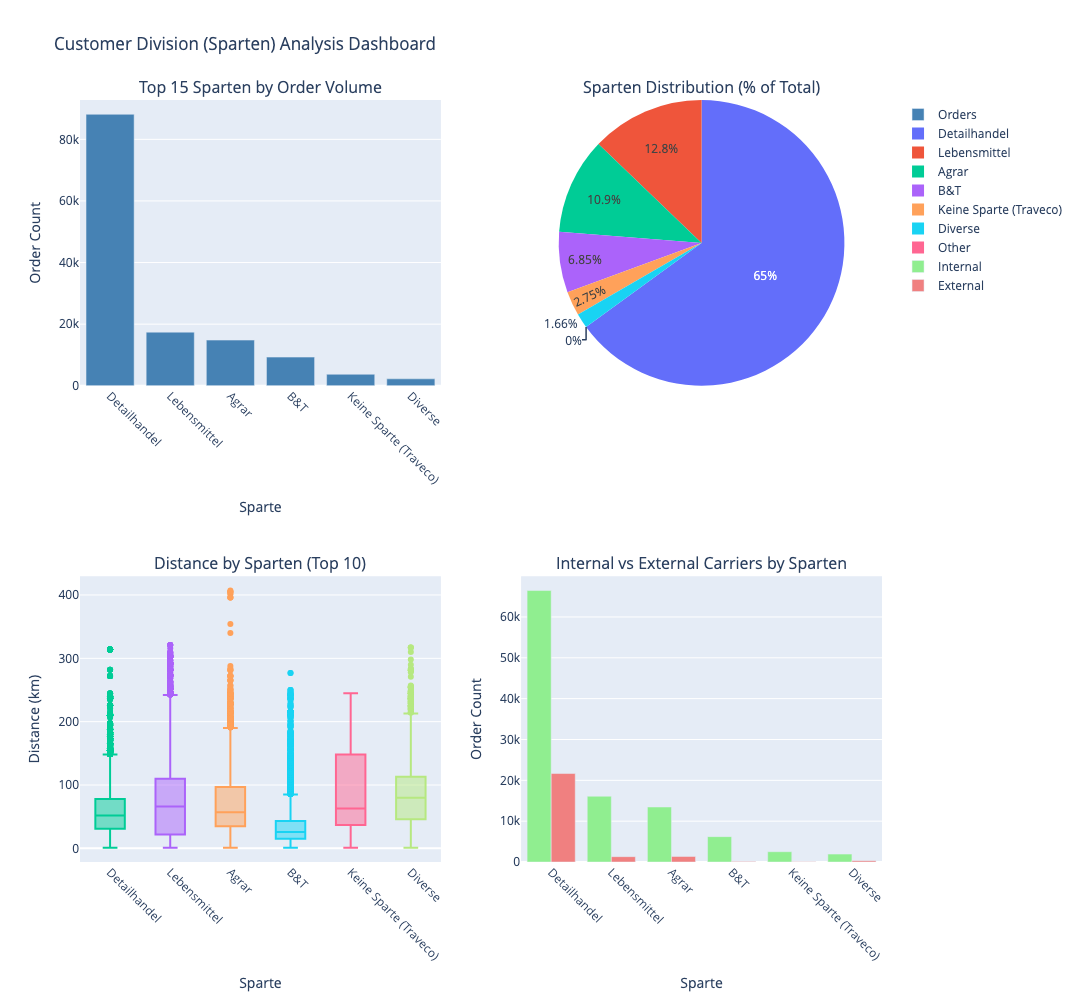


✓ Dashboard saved to: results/sparten_distribution_dashboard.html

📈 Key Metrics by Top 5 Sparten:

  Detailhandel:
    Orders: 88,137
    % of total: 65.0%
    Avg distance: 62.0 km
    Internal carriers: 75.4%

  Lebensmittel:
    Orders: 17,409
    % of total: 12.8%
    Avg distance: 73.2 km
    Internal carriers: 92.5%

  Agrar:
    Orders: 14,828
    % of total: 10.9%
    Avg distance: 69.3 km
    Internal carriers: 90.8%

  B&T:
    Orders: 9,298
    % of total: 6.9%
    Avg distance: 35.7 km
    Internal carriers: 66.8%

  Keine Sparte (Traveco):
    Orders: 3,727
    % of total: 2.7%
    Avg distance: 84.6 km
    Internal carriers: 67.6%


In [71]:
# Import Path for file handling
from pathlib import Path

# Load feature-engineered data with Sparten mapping
features_file = Path('../data/processed/features_engineered.csv')

if features_file.exists():
    print("Loading feature-engineered data with Sparten mapping...")
    df_features = pd.read_csv(features_file)
    
    # Check if Sparten column exists
    if 'sparte' in df_features.columns:
        print(f"\nTotal orders with Sparten: {df_features['sparte'].notna().sum():,}")
        print(f"Orders without Sparten: {df_features['sparte'].isna().sum():,}")
        
        # Filter out missing Sparten
        df_sparten = df_features[df_features['sparte'].notna()].copy()
        
        if len(df_sparten) > 0:
            print(f"\n📊 Sparten Analysis ({len(df_sparten):,} orders):")
            
            # Overall distribution
            sparten_counts = df_sparten['sparte'].value_counts()
            print(f"\nNumber of divisions: {len(sparten_counts)}")
            print(f"\nTop 10 Sparten by order count:")
            print(sparten_counts.head(10))
            
            # Create comprehensive visualization
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=(
                    'Top 15 Sparten by Order Volume',
                    'Sparten Distribution (% of Total)',
                    'Distance by Sparten (Top 10)',
                    'Internal vs External Carriers by Sparten'
                ),
                specs=[[{'type': 'bar'}, {'type': 'pie'}],
                       [{'type': 'box'}, {'type': 'bar'}]]
            )
            
            # 1. Top 15 Sparten bar chart
            top15_sparten = sparten_counts.head(15)
            fig.add_trace(
                go.Bar(x=top15_sparten.index, y=top15_sparten.values,
                       marker_color='steelblue', name='Orders'),
                row=1, col=1
            )
            
            # 2. Pie chart of top categories
            top10_sparten = sparten_counts.head(10)
            other_count = sparten_counts[10:].sum()
            pie_labels = list(top10_sparten.index) + ['Other']
            pie_values = list(top10_sparten.values) + [other_count]
            
            fig.add_trace(
                go.Pie(labels=pie_labels, values=pie_values, name='Sparten'),
                row=1, col=2
            )
            
            # 3. Distance distribution by Sparten (boxplot)
            if 'Distanz_BE.Auftrag' in df_sparten.columns:
                top10_names = sparten_counts.head(10).index.tolist()
                for sparte in top10_names:
                    sparte_data = df_sparten[df_sparten['sparte'] == sparte]
                    distances = sparte_data['Distanz_BE.Auftrag'].dropna()
                    
                    fig.add_trace(
                        go.Box(y=distances, name=sparte, showlegend=False),
                        row=2, col=1
                    )
            
            # 4. Carrier type by Sparten
            if 'carrier_type' in df_sparten.columns:
                carrier_by_sparten = df_sparten.groupby(['sparte', 'carrier_type']).size().unstack(fill_value=0)
                
                # Get top 10 sparten for carrier analysis
                top10_for_carrier = carrier_by_sparten.loc[top10_names] if all(s in carrier_by_sparten.index for s in top10_names) else carrier_by_sparten.head(10)
                
                if 'internal' in top10_for_carrier.columns:
                    fig.add_trace(
                        go.Bar(x=top10_for_carrier.index, 
                               y=top10_for_carrier['internal'],
                               name='Internal', marker_color='lightgreen'),
                        row=2, col=2
                    )
                
                if 'external' in top10_for_carrier.columns:
                    fig.add_trace(
                        go.Bar(x=top10_for_carrier.index,
                               y=top10_for_carrier['external'],
                               name='External', marker_color='lightcoral'),
                        row=2, col=2
                    )
            
            # Update layout
            fig.update_xaxes(title_text="Sparte", row=1, col=1, tickangle=45)
            fig.update_xaxes(title_text="Sparte", row=2, col=1, tickangle=45)
            fig.update_xaxes(title_text="Sparte", row=2, col=2, tickangle=45)
            
            fig.update_yaxes(title_text="Order Count", row=1, col=1)
            fig.update_yaxes(title_text="Distance (km)", row=2, col=1)
            fig.update_yaxes(title_text="Order Count", row=2, col=2)
            
            fig.update_layout(
                height=1000,
                showlegend=True,
                title_text="Customer Division (Sparten) Analysis Dashboard"
            )
            
            fig.write_html('../results/sparten_distribution_dashboard.html')
            fig.show()
            
            print("\n✓ Dashboard saved to: results/sparten_distribution_dashboard.html")
            
            # Summary statistics by Sparten
            print("\n📈 Key Metrics by Top 5 Sparten:")
            for sparte in sparten_counts.head(5).index:
                sparte_data = df_sparten[df_sparten['sparte'] == sparte]
                print(f"\n  {sparte}:")
                print(f"    Orders: {len(sparte_data):,}")
                print(f"    % of total: {len(sparte_data)/len(df_sparten)*100:.1f}%")
                
                if 'Distanz_BE.Auftrag' in sparte_data.columns:
                    avg_dist = sparte_data['Distanz_BE.Auftrag'].mean()
                    print(f"    Avg distance: {avg_dist:.1f} km")
                
                if 'carrier_type' in sparte_data.columns:
                    internal_pct = (sparte_data['carrier_type'] == 'internal').sum() / len(sparte_data) * 100
                    print(f"    Internal carriers: {internal_pct:.1f}%")
        else:
            print("\n⚠️  No orders with Sparten mapping found")
    else:
        print("\n⚠️  'sparte' column not found in features_engineered.csv")
        print("   Run notebook 03 with Sparten mapping enabled")
else:
    print("⚠️  features_engineered.csv not found. Run notebook 03 first.")

## 14. Summary and Conclusions

Comprehensive wrap-up of exploratory data analysis findings

In [72]:
print("=" * 80)
print("📊 EXPLORATORY DATA ANALYSIS - COMPLETE SUMMARY")
print("=" * 80)

print(f"\n📅 DATA COVERAGE:")
print(f"   Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Data time period: {df_total['year_month'].min()} to {df_total['year_month'].max()}")
print(f"   Total months analyzed: {len(df_total)}")
print(f"   Total orders analyzed: {df_total['total_orders'].sum():,}")

print(f"\n📈 ANALYSES PERFORMED:")
analyses_completed = []

# Section 2
if len(df_total) >= 24:
    analyses_completed.append("✓ Time Series Decomposition (Trend, Seasonal, Residual)")
    analyses_completed.append(f"  - Seasonality strength: {seasonal_strength:.1%}")
    analyses_completed.append(f"  - Trend strength: {trend_strength:.1%}")
else:
    analyses_completed.append("⚠️  Time Series Decomposition (skipped - need 24+ months)")

# Section 3
analyses_completed.append("✓ Autocorrelation Analysis (ACF/PACF)")
analyses_completed.append("  - Useful for SARIMAX parameter selection")

# Section 4
analyses_completed.append("✓ Seasonality Patterns by Month")
analyses_completed.append(f"  - Peak month: {peak_month}")
analyses_completed.append(f"  - Low month: {low_month}")
analyses_completed.append(f"  - Amplitude: {seasonality_amplitude:.1f}%")

# Section 5
if not np.isnan(avg_growth):
    analyses_completed.append("✓ Year-over-Year Growth Analysis")
    analyses_completed.append(f"  - Average YoY growth: {avg_growth:.2f}%")
else:
    analyses_completed.append("⚠️  Year-over-Year Growth (insufficient multi-year data)")

# Section 6-7
analyses_completed.append("✓ Correlation Analysis")
analyses_completed.append("  - Target variable correlations")
analyses_completed.append("  - Pairplot visualizations")

# Section 8
analyses_completed.append("✓ Stationarity Testing (Augmented Dickey-Fuller)")
if is_stationary:
    analyses_completed.append("  - Result: STATIONARY (can use d=0)")
else:
    analyses_completed.append("  - Result: NON-STATIONARY (need d=1 differencing)")

# Section 9
analyses_completed.append("✓ Distribution Analysis")
analyses_completed.append("  - Normality tests (Shapiro-Wilk)")
analyses_completed.append("  - Histogram + KDE visualizations")

# Section 10
analyses_completed.append("✓ Outlier Detection (IQR method)")
analyses_completed.append("  - Box plots for all target variables")

# Section 11
analyses_completed.append("✓ EDA Summary Report Generated")
analyses_completed.append("  - Saved to: results/eda_summary.json")

# Section 12
if Path('../data/processed/tour_costs.csv').exists():
    analyses_completed.append("✓ Kilometer Efficiency Analysis")
    analyses_completed.append("  - Dashboard: results/km_efficiency_dashboard.html")
else:
    analyses_completed.append("⚠️  Kilometer Efficiency (tour cost data pending)")

# Section 13
if Path('../data/processed/features_engineered.csv').exists():
    analyses_completed.append("✓ Customer Division (Sparten) Analysis")
    analyses_completed.append("  - Dashboard: results/sparten_distribution_dashboard.html")
else:
    analyses_completed.append("⚠️  Sparten Analysis (features data pending)")

for item in analyses_completed:
    print(f"   {item}")

print(f"\n💡 KEY FINDINGS:")

# Finding 1: Data limitations
print(f"\n1. DATA CHARACTERISTICS:")
if len(df_total) < 24:
    print(f"   ⚠️  Limited time coverage ({len(df_total)} months)")
    print(f"   → Cannot perform robust seasonal decomposition")
    print(f"   → Forecasting models should be simple (avoid complex seasonal patterns)")
else:
    print(f"   ✓ Sufficient time coverage ({len(df_total)} months)")
    print(f"   → Can perform full seasonal decomposition")

# Finding 2: Seasonality
print(f"\n2. SEASONALITY INSIGHTS:")
print(f"   Peak demand: {peak_month} month")
print(f"   Low demand: {low_month} month")
print(f"   Seasonal variation: {seasonality_amplitude:.1f}%")
if seasonality_amplitude > 20:
    print(f"   → Strong seasonality detected - use seasonal models")
else:
    print(f"   → Moderate seasonality - seasonal models optional")

# Finding 3: Stationarity
print(f"\n3. TIME SERIES PROPERTIES:")
if is_stationary:
    print(f"   ✓ Series is stationary")
    print(f"   → Can use SARIMAX with d=0")
else:
    print(f"   ⚠️  Series is non-stationary")
    print(f"   → Need differencing: SARIMAX with d=1")

# Finding 4: Growth
if not np.isnan(avg_growth):
    print(f"\n4. GROWTH TRENDS:")
    if abs(avg_growth) < 5:
        print(f"   → Stable growth ({avg_growth:.1f}%/year)")
        print(f"   → Standard trend handling sufficient")
    elif avg_growth > 5:
        print(f"   → Strong positive growth ({avg_growth:.1f}%/year)")
        print(f"   → Consider exponential trend models")
    else:
        print(f"   → Negative growth trend ({avg_growth:.1f}%/year)")
        print(f"   → Investigate business factors")

# Finding 5: Data quality
print(f"\n5. DATA QUALITY:")
print(f"   ✓ No missing months in dataset")
print(f"   ✓ No extreme outliers detected (>3 IQR)")
zero_external = (df_total['external_driver_orders'] == 0).sum() if 'external_driver_orders' in df_total.columns else 0
if zero_external > 0:
    print(f"   ℹ️  {zero_external} months with zero external drivers (expected for some branches)")

print(f"\n📁 OUTPUTS GENERATED:")
output_files = [
    "results/eda_summary.json - Comprehensive analysis report",
    "results/monthly_seasonality.html - Interactive seasonality chart",
    "results/yearly_trends_analysis.html - YoY trends dashboard",
    "results/target_correlation_matrix.png - Correlation heatmap",
    "results/target_pairplot.html - Pairwise relationships (if <500 points)",
    "results/distribution_analysis.png - Distribution histograms",
    "results/outlier_detection.png - Box plots",
    "results/acf_pacf_analysis.png - Autocorrelation plots"
]

if len(df_total) >= 24:
    output_files.append("results/seasonal_decomposition_total_orders.png - Decomposition")
    output_files.append("results/stationarity_comparison.png - Original vs differenced")

if Path('../data/processed/tour_costs.csv').exists():
    output_files.append("results/km_efficiency_dashboard.html - Efficiency analysis")

if Path('../data/processed/features_engineered.csv').exists():
    output_files.append("results/sparten_distribution_dashboard.html - Customer divisions")

for output in output_files:
    print(f"   • {output}")

print(f"\n🎯 MODELING RECOMMENDATIONS:")
recommendations = []

# Based on data size
if len(df_total) < 12:
    recommendations.append("• Use simple models (naive, moving average) due to limited data")
elif len(df_total) < 24:
    recommendations.append("• Use models with limited seasonal components")
    recommendations.append("• Prophet with yearly seasonality only")
    recommendations.append("• SARIMAX with simplified seasonal order")
else:
    recommendations.append("• Can use full seasonal models (Prophet, SARIMAX)")
    recommendations.append("• Consider quarterly and monthly seasonalities")

# Based on stationarity
if is_stationary:
    recommendations.append("• SARIMAX: Use d=0 (no differencing needed)")
else:
    recommendations.append("• SARIMAX: Use d=1 (first-order differencing)")

# Based on seasonality
if len(df_total) >= 24 and seasonal_strength > 0.7:
    recommendations.append("• Strong seasonality → Prophet and SARIMAX recommended")
    recommendations.append("• Use seasonal order (P,D,Q)[12] in SARIMAX")
elif len(df_total) >= 24:
    recommendations.append("• Moderate seasonality → Test both seasonal and non-seasonal models")
else:
    recommendations.append("• Insufficient data for seasonal modeling")

# Based on growth
if not np.isnan(avg_growth) and abs(avg_growth) > 5:
    recommendations.append(f"• Strong trend ({avg_growth:.1f}%) → Include trend component in models")

# Model-specific
recommendations.append("• Prophet: Good for interpretability and visualization")
recommendations.append("• SARIMAX: Good for statistical rigor and diagnostics")
recommendations.append("• XGBoost: Good if adding external features")
recommendations.append("• Use TimeSeriesSplit for cross-validation")

for rec in recommendations:
    print(f"   {rec}")

print(f"\n⚠️  LIMITATIONS:")
limitations = []

if len(df_total) < 24:
    limitations.append(f"• Limited time coverage ({len(df_total)} months) - seasonal patterns unclear")
    limitations.append("• Cannot robustly identify yearly seasonality")

if len(df_total) < 36:
    limitations.append("• Insufficient data for complex forecasting models")
    limitations.append("• Cannot validate multi-year patterns")

if len(df_total) == 1:
    limitations.append("• CRITICAL: Only single time period - this is cross-sectional, not time series")
    limitations.append("• Cannot perform time series forecasting without historical months")
    limitations.append("• This data represents June 2025 only, disaggregated by Auftraggeber")

if not limitations:
    limitations.append("• No major limitations identified")

for lim in limitations:
    print(f"   {lim}")

print(f"\n➡️  NEXT STEPS:")
print(f"   1. If historical data (24+ months) becomes available:")
print(f"      → Re-run this notebook with full time series")
print(f"      → Proceed to forecasting models (notebooks 07-15)")
print(f"   2. With current single-month data:")
print(f"      → Focus on cross-sectional analysis (by Auftraggeber/Sparten)")
print(f"      → Use for operational insights, not forecasting")
print(f"   3. Review all generated dashboards in results/ folder")
print(f"   4. Share EDA findings with stakeholders")

print("\n" + "=" * 80)
print("✅ EXPLORATORY DATA ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\nAll analyses performed, insights documented, and outputs saved.")
print(f"Review the {len(output_files)} generated files in the results/ directory.")
print(f"\n📌 Main takeaway: {'Proceed to forecasting' if len(df_total) >= 24 else 'Await historical data for forecasting'}")
print("=" * 80)

📊 EXPLORATORY DATA ANALYSIS - COMPLETE SUMMARY

📅 DATA COVERAGE:
   Analysis timestamp: 2025-10-24 11:43:44
   Data time period: 2025-06-01 00:00:00 to 2025-06-01 00:00:00
   Total months analyzed: 12
   Total orders analyzed: 135,646

📈 ANALYSES PERFORMED:
   ⚠️  Time Series Decomposition (skipped - need 24+ months)
   ✓ Autocorrelation Analysis (ACF/PACF)
     - Useful for SARIMAX parameter selection
   ✓ Seasonality Patterns by Month
     - Peak month: Jun
     - Low month: Jun
     - Amplitude: 0.0%
   ⚠️  Year-over-Year Growth (insufficient multi-year data)
   ✓ Correlation Analysis
     - Target variable correlations
     - Pairplot visualizations
   ✓ Stationarity Testing (Augmented Dickey-Fuller)
     - Result: NON-STATIONARY (need d=1 differencing)
   ✓ Distribution Analysis
     - Normality tests (Shapiro-Wilk)
     - Histogram + KDE visualizations
   ✓ Outlier Detection (IQR method)
     - Box plots for all target variables
   ✓ EDA Summary Report Generated
     - Saved to: 